In [1]:
## Standard libraries
import os
import pandas as pd
from tabulate import tabulate

## Seeds
import random
import numpy as np

## PyTorch
import torch
import torch.utils.data as data

# Custom libraries
from networks.SimpleMLPs import MLPsumV2
from dataloader_pickles import DataloaderEvalV5
import utils
from pytorch_metric_learning import losses, distances


## UMAP libraries
import matplotlib.pyplot as plt
import umap.plot
import matplotlib as mpl
import copy
import plotly.express as px



NUM_WORKERS = 0
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Set random seed for reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)


In [2]:
#%%
# Load model
save_name_extension = 'general_ckpt_simpleMLP_V1'
model_name = save_name_extension
print('Loading:', model_name)

input_dim = 1324
kFilters = 1/2
latent_dim = 2048
output_dim = 2048
model = MLPsumV2(input_dim=input_dim, latent_dim=latent_dim, output_dim=output_dim,
                 k=kFilters, dropout=0, cell_layers=1,
                 proj_layers=2, reduction='sum')
if torch.cuda.is_available():
    model.cuda()

path = r'/Users/rdijk/PycharmProjects/featureAggregation/wandb/run-20220505_221947-1m1zas58/files'

models = os.listdir(path)
fullpath = os.path.join(path, model_name)
if 'ckpt' in model_name:
    model.load_state_dict(torch.load(fullpath)['model_state_dict'])
else:
    model.load_state_dict(torch.load(fullpath))
model.eval()

#%% Select specific plate and well
plates = ['BR00112197binned_FS']
well = ['M08']

Loading: general_ckpt_simpleMLP_V1


In [3]:
#%%
# Load all data
rootDir = r'/Users/rdijk/PycharmProjects/featureAggregation/datasets/Stain2'
metadata = pd.read_csv('/Users/rdijk/Documents/Data/RawData/Stain2/JUMP-MOA_compound_platemap_with_metadata.csv', index_col=False)
plateDirs = [x[0] for x in os.walk(rootDir)][1:]

plateDirs = [x for x in plateDirs if any(substr in x for substr in plates)]

platestring = plateDirs[0].split('_')[-2]
print('Calculating results for: ' + platestring)
metadata = utils.addDataPathsToMetadata(rootDir, metadata, plateDirs)

# Filter the data and create numerical labels
df_prep = utils.filterData(metadata, '', encode='pert_iname')
df_prep = df_prep.loc[df_prep.well_position == well[0]]
# Add all data to one DF
Total, _ = utils.train_val_split(df_prep, 1.0, sort=False)

valset = DataloaderEvalV5(Total)
loader = data.DataLoader(valset, batch_size=1, shuffle=False, # 96
                         drop_last=False, pin_memory=False, num_workers=NUM_WORKERS)


Calculating results for: BR00112197binned


In [4]:
df_prep.head()

,well_position,broad_sample,solvent,InChIKey,pert_iname,pubchem_cid,moa,smiles,pert_type,control_type,plate1,Metadata_labels
295,M08,BRD-K73397362-001-06-6,DMSO,FYBHCRQFSFYWPY-UHFFFAOYSA-N,purmorphamine,5284329.0,smoothened receptor agonist,C1CCC(CC1)n1cnc2c(Nc3ccc(cc3)N3CCOCC3)nc(Oc3cc...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,81


In [5]:
points, label = next(iter(loader))
print(points.shape)
print(label)

torch.Size([1, 3147, 1324])
tensor([81], dtype=torch.int16)


In [6]:
single_cell_profiles = torch.tensor([])
final_profile, _ = model(points)

for idx in range(points.shape[1]):
    single_cell = points[:, [idx], :]
    sc_profile, _ = model(single_cell)
    single_cell_profiles = torch.cat([single_cell_profiles, sc_profile])
single_cell_profiles = single_cell_profiles.detach().numpy()
final_profile = final_profile.detach().numpy()

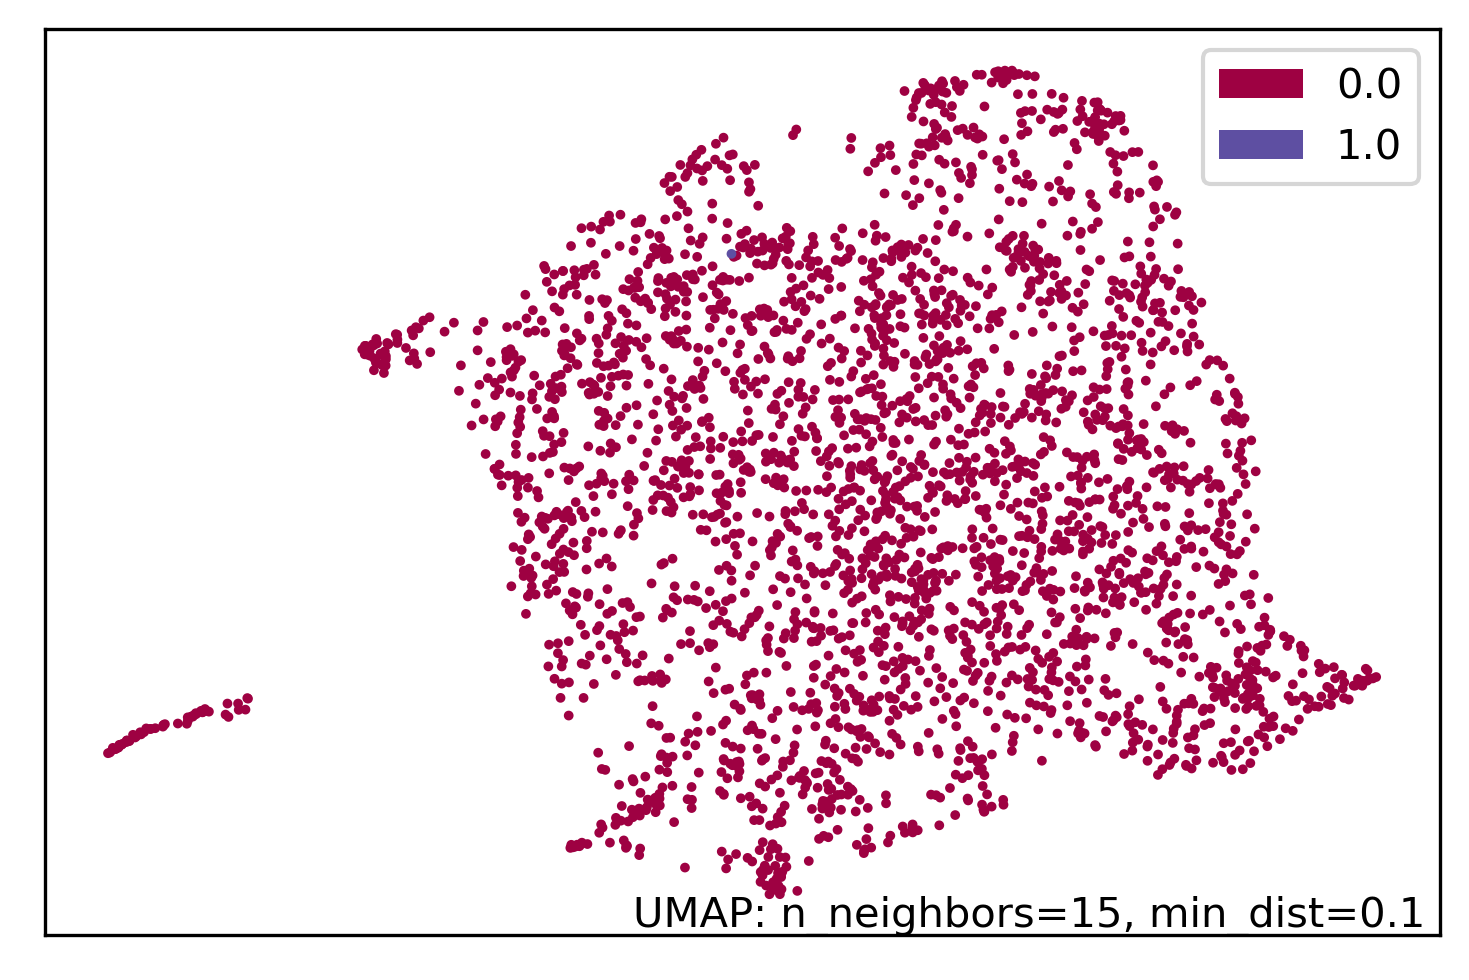

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit(np.concatenate([single_cell_profiles, final_profile]))
labels = np.zeros(embedding.embedding_.shape[0])
labels[-1] = 1
fig, ax = plt.subplots(1, 1, dpi=300)
umap.plot.points(embedding, labels=labels, ax=ax)
plt.show()
cos = cosine_similarity(single_cell_profiles, final_profile)[:, 0]

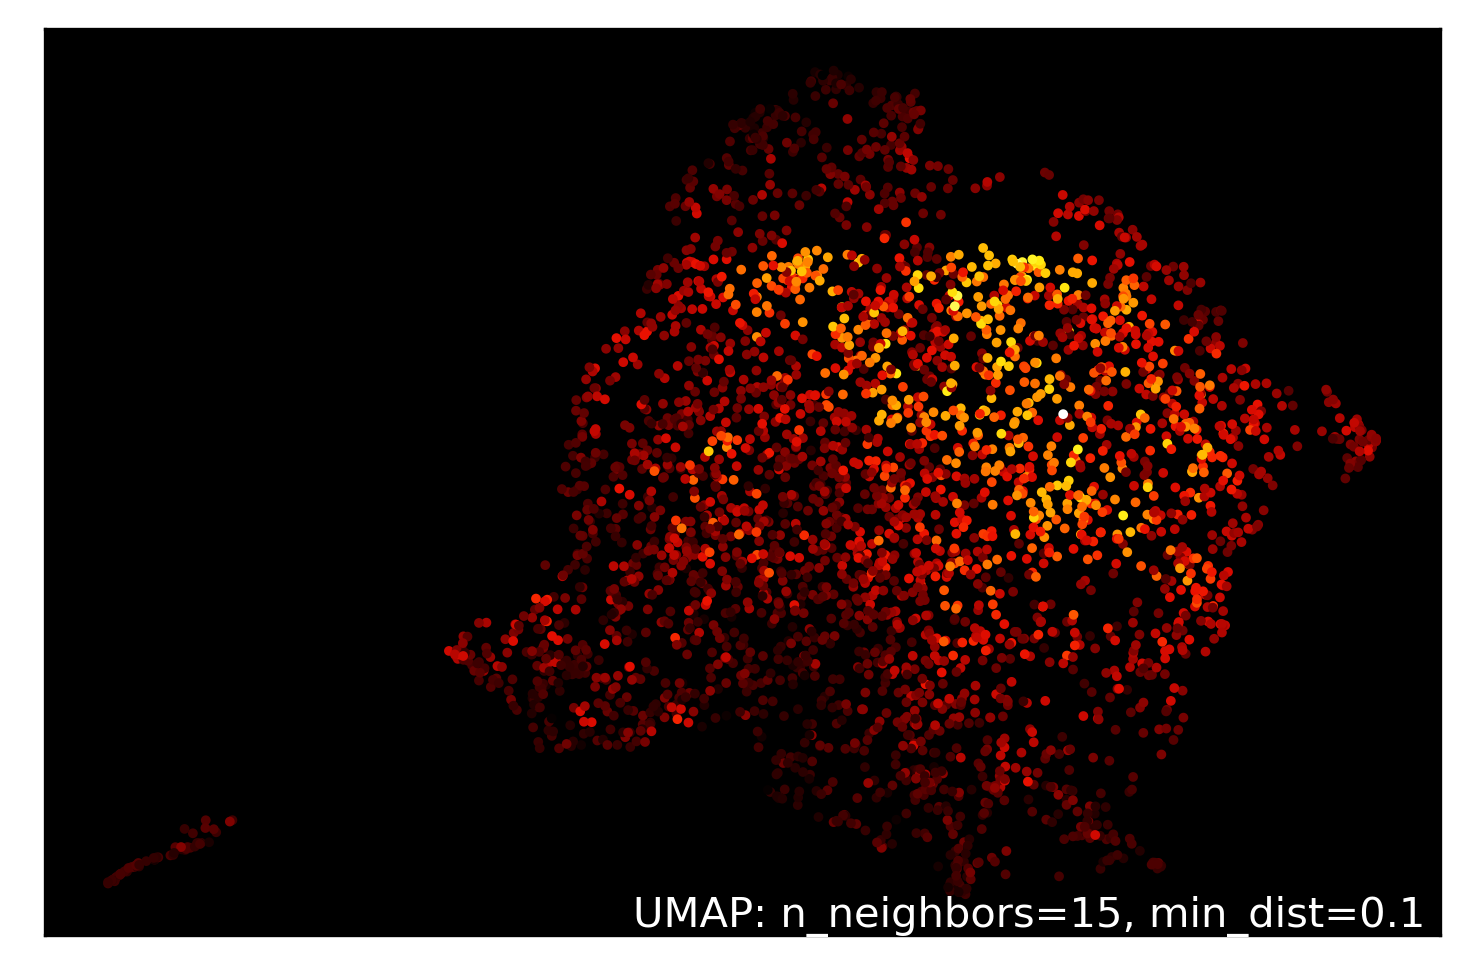

In [8]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit(single_cell_profiles)

fig, ax = plt.subplots(1, 1, dpi=300)

umap.plot.points(embedding, values=cos, theme='fire', ax=ax)
# psm = plt.pcolormesh([cos, cos], cmap=mpl.cm.get_cmap('fire'))
# cb = plt.colorbar(psm, ax=ax)

plt.show()